In [1]:
#Imports
import sys
sys.path.append('../python/')
#import NGC5533_functions-newmag as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp
import scipy.interpolate as inter
#import noordermeer as noord

from datetime import datetime
import time

In [20]:
#import data files:
starttime = time.time()

#TRACING:**************************************
#data points:
data = dp.getXYdata_wXYerr('../NGC_5005/traced_data/ngc5005_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])
#v_err1=v_err1[:len(v_err1)-1]
#r_dat=r_dat[:len(r_dat)-1]
#v_dat=v_dat[:len(v_dat)-1]

#gas rotmod:
gas_rdata = dp.getXYZdata('rotmod_gas.dat')
rgasr = gas_rdata['xx']
rgasv = gas_rdata['zz']
rgasv=np.asarray(rgasv)
rgasv_spline = inter.InterpolatedUnivariateSpline(rgasr,rgasv,k=5)
rgasv_fit = rgasv_spline(r_dat)

#make gas array same length as data points array ????? how can I fit without doing this?????
#rgasv=rgasv[:len(rgasv)-5]
#rgasv=rgasv[0::72]

#bulge rotmod:
bulge_rdata = dp.getXYZdata('bulgebulge.dat')
rbulger = bulge_rdata['xx']
rbulgev = bulge_rdata['zz']
rbulgev=np.asarray(rbulgev)
#rbulger = [x - 1.15 for x in rbulger]
#rbulger=rbulger[:len(rbulger)-5]
#rbulger=rbulger[0::72]
#rbulgev=rbulgev[:len(rbulgev)-5]
#rbulgev=rbulgev[0::72]
rbulgev_spline = inter.InterpolatedUnivariateSpline(rbulger,rbulgev,k=5)
rbulgev_fit = rbulgev_spline(r_dat)

#manually replacing "peak" in bulge to true peak
#not sure if this makes a difference
#rbulger[1] = .58 #.409 from trace
#rbulgev[1]=653.7

#disk rotmod:
disk_rdata = dp.getXYZdata('diskdisk.dat')
rdiskr = disk_rdata['xx']
rdiskv = disk_rdata['zz']
rdiskv=np.asarray(rdiskv)
#rdiskv=rdiskv[:len(rdiskv)-5]
#rdiskv=rdiskv[0::72]
rdiskv_spline = inter.InterpolatedUnivariateSpline(rdiskr,rdiskv,k=5)
rdiskv_fit = rdiskv_spline(r_dat)

#Halo datathief trace:
halo_dt = dp.getXYdata('../NGC_5005/datatheif_halo_spline.txt')
halo_dtr = halo_dt['xx']
halo_dtv = halo_dt['yy']
halo_dtv=np.asarray(halo_dtv)
#halo_dtv=halo_dtv[:len(halo_dtv)-5]
#halo_dtv=halo_dtv[0::6]
halo_dtv_spline = inter.InterpolatedUnivariateSpline(halo_dtr,halo_dtv,k=5)
halo_dtv_fit = halo_dtv_spline(r_dat)

rval = np.linspace(0,12,18)
#print(len(rval))
#print(len(rbulgev))
#print(len(rgasv))
#print(len(rdiskv))
print(halo_dtr)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.0, 11.1, 11.2]


In [3]:
# Fitting function, just prefactors for all the components
def g(r,GX,BX,DX,HX):
    return np.sqrt((GX*rgasv_fit)**2 
                   + (BX*rbulgev_fit)**2 
                   + (DX*rdiskv_fit)**2
                   + (HX*halo_dtv_fit)**2)

In [4]:
weighdata=1/v_err1
# LMFit

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()
#Gas
g_params.add('GX', value=1, min=.9, max=1.1) #Mass

#Bulge
g_params.add('BX', value=1, min=0)          #Prefactor

#Disk
g_params.add('DX', value=1, min=0)       #Prefactor
#Halo
g_params.add('HX', value=1, min=0)          #Core radius (kpc)

#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weighdata)

In [5]:
# Define for plotting
bestg = g_fit.best_fit
#delg = g_fit.eval_uncertainty()
print('Fit information for all-component fit:')
g_fit

Fit information for all-component fit:


In [25]:
#smoothing --> creating a spline
#print(bestg)

rval = np.arange(0,15,0.1)


#for total fit curve
#r_dat = r_dat[r_dat.argsort()]
r_dat_andzero = np.append([0],r_dat)
idx = np.arange(0,np.shape(r_dat_andzero)[0])

bestg = bestg[r_dat.argsort()]
f_v_T = inter.InterpolatedUnivariateSpline(r_dat_andzero[idx%1==0], np.append([0],bestg)[idx%1==0], k=3)
f_v_T_v = np.vectorize(f_v_T)

"""
#for gas:
rgasv = rgasv[rval.argsort()]
f_v_G = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rgasv[idx%1==0], k=5)
f_v_G_v = np.vectorize(f_v_G)

#for disk:
rdiskv = rdiskv[rval.argsort()]
f_v_D = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rdiskv[idx%1==0], k=5)
f_v_D_v = np.vectorize(f_v_D)

#for halo:
halo_dtv = halo_dtv[rval.argsort()]
f_v_H = inter.InterpolatedUnivariateSpline(rval[idx%1==0], halo_dtv[idx%1==0], k=5)
f_v_H_v = np.vectorize(f_v_H)

#for bulge:
rbulgev = rbulgev[rval.argsort()]
f_v_B = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rbulgev[idx%1==0], k=5)
f_v_B_v = np.vectorize(f_v_B)
"""

'\n#for gas:\nrgasv = rgasv[rval.argsort()]\nf_v_G = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rgasv[idx%1==0], k=5)\nf_v_G_v = np.vectorize(f_v_G)\n\n#for disk:\nrdiskv = rdiskv[rval.argsort()]\nf_v_D = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rdiskv[idx%1==0], k=5)\nf_v_D_v = np.vectorize(f_v_D)\n\n#for halo:\nhalo_dtv = halo_dtv[rval.argsort()]\nf_v_H = inter.InterpolatedUnivariateSpline(rval[idx%1==0], halo_dtv[idx%1==0], k=5)\nf_v_H_v = np.vectorize(f_v_H)\n\n#for bulge:\nrbulgev = rbulgev[rval.argsort()]\nf_v_B = inter.InterpolatedUnivariateSpline(rval[idx%1==0], rbulgev[idx%1==0], k=5)\nf_v_B_v = np.vectorize(f_v_B)\n'

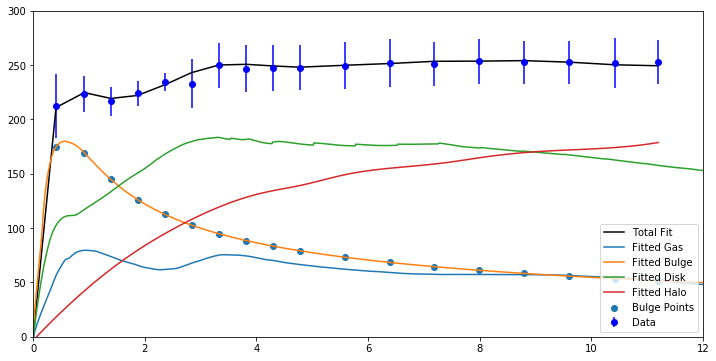

In [28]:
# Define for plotting cont.

rval = np.arange(0,12,0.1)
g_dict = g_fit.best_values
g_g = g_dict['GX']
g_b = g_dict['BX']
g_d = g_dict['DX']
g_h = g_dict['HX']

plt.figure(figsize=(12,6))
plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(rval,f_v_T_v(rval),'k',label='Total Fit')
plt.plot(r_dat_andzero,np.append([0],bestg),'k',label='Total Fit')
plt.plot(rgasr,g_g*rgasv,label='Fitted Gas')


plt.plot(rbulger,g_b*rbulgev,label='Fitted Bulge')
plt.scatter(r_dat,g_b*rbulgev_spline(r_dat),label='Bulge Points') #confusion


plt.plot(rdiskr,g_d*rdiskv,label='Fitted Disk')
plt.plot(halo_dtr,g_h*halo_dtv,label='Fitted Halo')
#plt.plot(rval,f_v_T_v(rval)-g_h*f_v_H_v(rval),label='Baryonic (visible) matter')

plt.legend(loc='lower right')
plt.ylim(0,300)
plt.xlim(0,12)
plt.show()

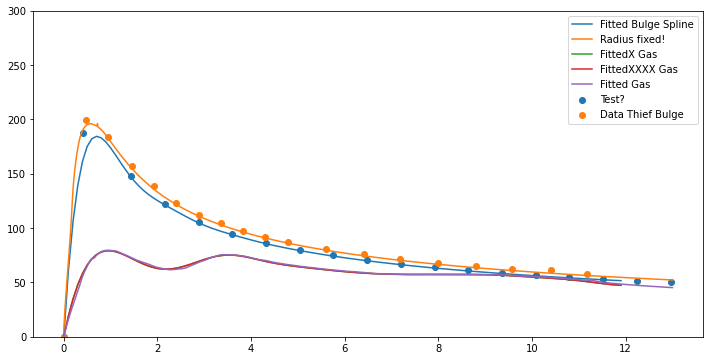

[  0.        559.9375992 518.0210994 442.063923  390.13296   346.2089526
 316.317519  294.4291014 274.5391866 258.6595032 244.7867646 227.0048172
 213.2246592 201.4427226 191.6725146 183.9008094 176.1248832 172.3670676
 162.5841966]
[0.0, 0.4735, 0.9489, 1.4522, 1.9277, 2.3892, 2.8928, 3.3684, 3.83, 4.3059, 4.7955, 5.6072, 6.4048, 7.1885, 8.0002, 8.7979, 9.5816, 10.4073, 11.177]
[  0.       653.7      518.065655 427.531198 370.313647 331.218595
 302.359827 279.930805 261.851291 246.875765 234.206915 223.307531
 213.800684 205.413053 197.94097  191.229145 185.156824 179.628504
 174.567527]
[0.0, 0.409, 1.44, 2.16, 2.88, 3.6, 4.32, 5.04, 5.76, 6.48, 7.2, 7.92, 8.64, 9.36, 10.08, 10.8, 11.52, 12.24, 12.96]
[  0.       653.7      518.065655 427.531198 370.313647 331.218595
 302.359827 279.930805 261.851291 246.875765 234.206915 223.307531
 213.800684 205.413053 197.94097  191.229145 185.156824 179.628504
 174.567527]
[0.0, 0.409, 1.44, 2.16, 2.88, 3.6, 4.32, 5.04, 5.76, 6.48, 7.2, 7.92, 8.

In [8]:
#****TROUBLESHOOTING**************
plt.figure(figsize=(12,6))

bulge = dp.getXYdata('../NGC_5005/traced_data/ngc5005_bulge.txt')
bulgerr = bulge['xx']
bulgevv = bulge['yy']
bulgevv=np.asarray(bulgevv)

#bulge rotmod:
bulgebulge = dp.getXYZdata('bulgebulge.dat')
bulgebulger = bulgebulge['xx']
bulgebulgev = bulgebulge['zz']
bulgebulgev=np.asarray(bulgebulgev)


Xbulger=bulgebulger[:len(rbulger)-5]
Xbulger=bulgebulger[0::72]

Xbulgev=bulgebulgev[:len(rbulgev)-5]
Xbulgev=bulgebulgev[0::72]


gas_rdata = dp.getXYZdata('rotmod_gas.dat')
rgasr = gas_rdata['xx']
rgasv = gas_rdata['zz']
rgasv=np.asarray(rgasv)


gas_rdata = dp.getXYZdata('rotmod_gas.dat')
rgasr = gas_rdata['xx']
rgasv = gas_rdata['zz']
rgasv=np.asarray(rgasv)


gas_rdata = dp.getXYZdata('gas_from_0.txt')
rgasrX = gas_rdata['xx']
rgasvX = gas_rdata['zz']
rgasvX=np.asarray(rgasvX)
Xbulger[1] = .409
Xbulgev[1]=653.7
plt.scatter(Xbulger,g_b*Xbulgev,label='Test?')

plt.plot(rval,g_b*f_v_B_v(rval),label='Fitted Bulge Spline')
#plt.scatter(rbulger,g_b*rbulgev,label='Fitted Bulge Points') #confusion
plt.scatter(bulgerr,bulgevv,label='Data Thief Bulge')
plt.plot(bulgebulger,.3*bulgebulgev,label='Radius fixed!')
plt.plot(rval,g_g*f_v_G_v(rval),label='FittedX Gas')
plt.plot(rval,g_g*f_v_G_v(rval),label='FittedXXXX Gas')
plt.plot(rgasrX,rgasvX,label='Fitted Gas')
plt.legend(loc='upper right')
plt.ylim(0,300)
#plt.xlim(0,14)
plt.show()

#print(g_b*rbulgev)
#print(bulgerr)
print(2.814*bulgevv)
print(bulgerr)
print(Xbulgev)
print(Xbulger)


print(Xbulgev)
print(Xbulger)